## Network in Network (NiN)

![NiN Block.](http://www.d2l.ai/_images/nin-compare.svg)

In [1]:
!pip install mxnet-cu100
!pip install d2l

     |████████████████████████████████| 540.1MB 30kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for d2l: filename=d2l-0.10.1-cp36-none-any.whl size=16622 sha256=dde038378fab55baa240be095a372443ae80df61874d705fe641f8d56c3c05e1
  Stored in directory: /root/.cache/pip/wheels/60/35/5d/df7f13dd4b012de688ffcc516091c6cd67c765dc64c9d1f43f
Successfully built d2l


In [0]:
import d2l
from mxnet import gluon, init, nd
from mxnet.gluon import nn

In [0]:
def nin_block(num_channels, kernel_size, strides, padding):
    blk = nn.HybridSequential()
    blk.add(nn.Conv2D(num_channels, kernel_size, strides, padding, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'))
    return blk

**NiN Model**

In [0]:
net = nn.HybridSequential()
net.add(nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2D(pool_size=3, strides=2),
        nn.Dropout(0.5),
        # There are 10 label classes.
        nin_block(10, kernel_size=3, strides=1, padding=1),
        # The global average pooling layer aggregates over all entries
        nn.GlobalAvgPool2D(),
        # Transform the four-dimensional output into two-dimensional output
        nn.Flatten())

Output shapes throughout the network

In [5]:
X = nd.random.uniform(shape=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

hybridsequential1 output shape:	 (1, 96, 54, 54)
pool0 output shape:	 (1, 96, 26, 26)
hybridsequential2 output shape:	 (1, 256, 26, 26)
pool1 output shape:	 (1, 256, 12, 12)
hybridsequential3 output shape:	 (1, 384, 12, 12)
pool2 output shape:	 (1, 384, 5, 5)
dropout0 output shape:	 (1, 384, 5, 5)
hybridsequential4 output shape:	 (1, 10, 5, 5)
pool3 output shape:	 (1, 10, 1, 1)
flatten0 output shape:	 (1, 10)


**Training**

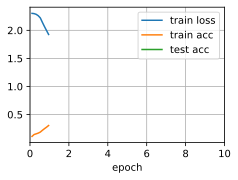

In [0]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)